##Preprocessing and EDA

In [113]:
import pandas as pd
import numpy as np

# Uploading Merged Data

In [114]:
df = pd.read_csv("Merged_Data.csv")

In [115]:
df.shape

(16486, 14)

In [116]:
df.head()

,client_collected,contact_method,pickup_date,age,dependents_qty,household,preferred_languages,sex_new,status,Season,Month,distance_km,num_of_contact_methods,latest_language_is_english
0,yes,In-Person,2023-08-22 10:45:00,56.0,1.0,yes,English,Female,Active,Summer,August,0.00,2,Yes
1,yes,In-Person,2023-09-07 17:37:00,36.0,6.0,yes,Arabic,Female,Active,Fall,September,7.49,2,No
2,yes,In-Person,2023-10-07 03:00:00,36.0,6.0,yes,Arabic,Female,Active,Fall,October,7.49,2,No
3,yes,In-Person,2023-11-07 15:59:00,36.0,6.0,yes,Arabic,Female,Active,Fall,November,7.49,2,No
4,yes,In-Person,2023-09-12 17:39:00,32.0,5.0,yes,"Arabic , French",Female,Active,Fall,September,15.30,3,No


##Modeling

In [117]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Sample DataFrame (replace this with your full dataset)
# df = pd.read_csv('your_data.csv')  # Assuming you've already loaded your dataframe

# Target variable
y = df['client_collected'].map({'yes': 1, 'no': 0})  # Convert to binary

# Drop columns that shouldn't be used as features
X = df.drop(['client_collected', 'pickup_date'], axis=1)  # pickup_date might leak info

# Define categorical and numerical columns
categorical_cols = ['contact_method', 'household', 'preferred_languages', 'sex_new', 'status', 'Season', 'Month', 'latest_language_is_english']
numerical_cols = ['age', 'dependents_qty', 'distance_km', 'num_of_contact_methods']

# Define preprocessing for both
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Define pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[  14  683]
 [   3 2598]]
              precision    recall  f1-score   support

           0       0.82      0.02      0.04       697
           1       0.79      1.00      0.88      2601

    accuracy                           0.79      3298
   macro avg       0.81      0.51      0.46      3298
weighted avg       0.80      0.79      0.70      3298



In [118]:
#  show feature importance

import pandas as pd
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = list(pipeline.named_steps['preprocessing'].named_transformers_['cat'].get_feature_names_out(categorical_cols)) + numerical_cols
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feature_importances.sort_values('importance', ascending=False))


                                   feature  importance
109                            Season_Fall    0.327951
110                          Season_Spring    0.084084
129                            distance_km    0.068599
128                         dependents_qty    0.064262
119                             Month_June    0.057052
..                                     ...         ...
10   preferred_languages_Amharic , English    0.000000
14   preferred_languages_Arabic , Armenian    0.000000
15    preferred_languages_Arabic , Bengali    0.000000
16    preferred_languages_Arabic , English    0.000000
0                 contact_method_In-Person    0.000000

[131 rows x 2 columns]


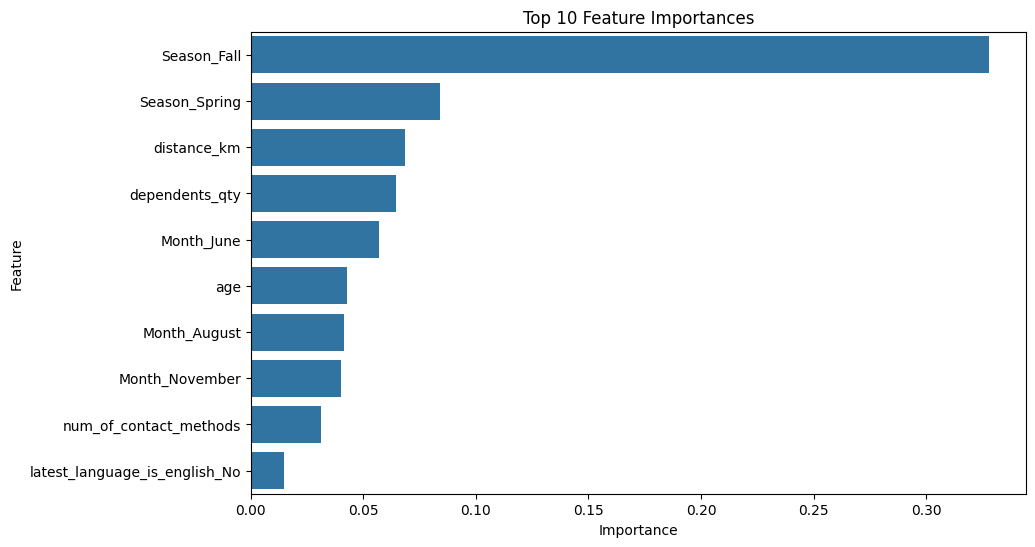

In [119]:
#  visualize top 10 features
import matplotlib.pyplot as plt
import seaborn as sns



# Assuming feature_importances DataFrame is already created as in the previous code

# Sort feature importances in descending order
feature_importances_sorted = feature_importances.sort_values('importance', ascending=False)

# Select top 10 features
top_10_features = feature_importances_sorted.head(10)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_10_features)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


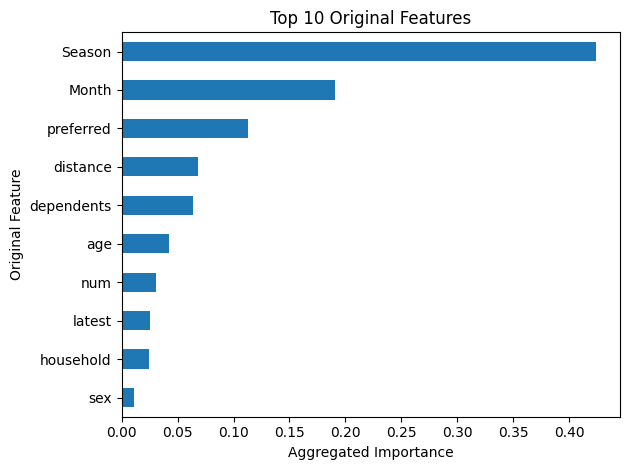

In [120]:
from sklearn.inspection import permutation_importance

# Get feature names from ColumnTransformer
# This works only if you named your transformers
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

# Combine all feature names
all_feature_names = np.concatenate([ohe_feature_names, numerical_cols])

# Get feature importances from model
importances = pipeline.named_steps['classifier'].feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'encoded_feature': all_feature_names,
    'importance': importances
})

# Map each encoded feature to original feature
feature_importance_df['original_feature'] = feature_importance_df['encoded_feature'].apply(
    lambda x: x.split('_')[0] if '_' in x else x
)

# Group by original feature
top_original = (
    feature_importance_df.groupby('original_feature')['importance']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Plot
top_original.plot(kind='barh', title='Top 10 Original Features')
plt.xlabel('Aggregated Importance')
plt.ylabel('Original Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Dealing with Data Imbalance

In [121]:
df['client_collected'].value_counts()

,count
client_collected,
yes,12880
no,3606


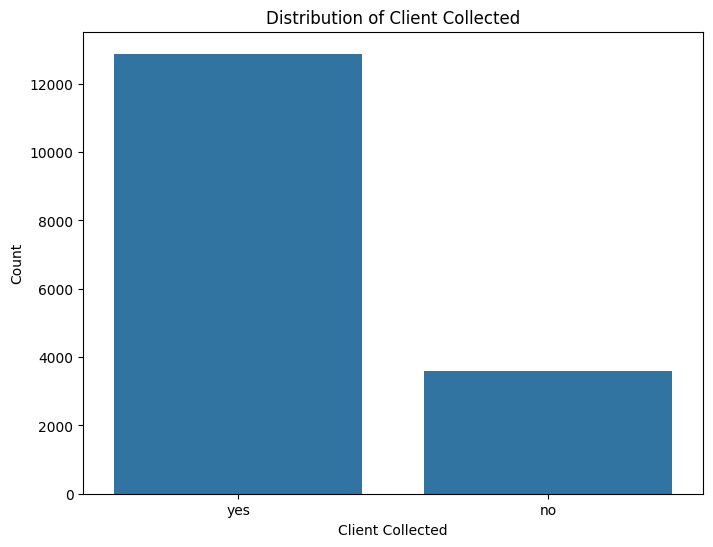

In [122]:
#  visualize "client_collected"

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='client_collected', data=df)
plt.title('Distribution of Client Collected')
plt.xlabel('Client Collected')
plt.ylabel('Count')
plt.show()


In [123]:
!pip install imbalanced-learn

### Option 1: Oversampling the Minority Class
### Use SMOTE (Synthetic Minority Oversampling Technique)

In [124]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Preprocessing remains the same
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# Define new pipeline using imblearn's Pipeline
pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 295  426]
 [ 501 2076]]
              precision    recall  f1-score   support

           0       0.37      0.41      0.39       721
           1       0.83      0.81      0.82      2577

    accuracy                           0.72      3298
   macro avg       0.60      0.61      0.60      3298
weighted avg       0.73      0.72      0.72      3298



### Option 2: Class Weights
If you prefer not to resample, you can assign higher weight to the minority class:

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

# Define classifier with balanced class weights (for models that support it)
# GradientBoostingClassifier does NOT support `class_weight`, but RandomForest or LogisticRegression do.
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit model
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[ 470  251]
 [1014 1563]]
              precision    recall  f1-score   support

           0       0.32      0.65      0.43       721
           1       0.86      0.61      0.71      2577

    accuracy                           0.62      3298
   macro avg       0.59      0.63      0.57      3298
weighted avg       0.74      0.62      0.65      3298



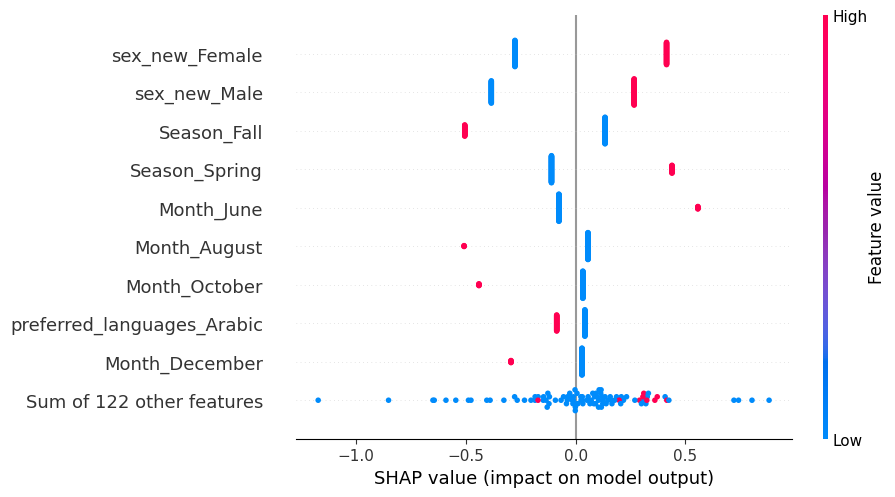

In [127]:
# Install SHAP if needed
!pip install shap --quiet

import shap
import numpy as np

# Preprocess test data
X_test_transformed = pipeline.named_steps['preprocessing'].transform(X_test)

# If the result is sparse matrix, convert to dense
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# Get feature names
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([ohe_feature_names, numerical_cols])

# Convert to DataFrame
X_test_df = pd.DataFrame(X_test_transformed, columns=all_feature_names)

# SHAP Explainer
model = pipeline.named_steps['classifier']
explainer = shap.Explainer(model, X_test_df)
shap_values = explainer(X_test_df.sample(100, random_state=1))  # Sample for speed

# Plot
shap.initjs()
shap.plots.beeswarm(shap_values)


In [128]:
import joblib

# Save pipeline
joblib.dump(pipeline, 'client_retention_model.pkl')

# Load later if needed
# pipeline = joblib.load('client_retention_model.pkl')


['client_retention_model.pkl']

In [129]:
def predict_new_client(client_data_dict):
    """
    Predict if a new client will return based on input features.
    client_data_dict: dict containing raw input data (same keys as X)
    """
    new_df = pd.DataFrame([client_data_dict])
    prediction = pipeline.predict(new_df)[0]
    probability = pipeline.predict_proba(new_df)[0][1]

    return {
        "prediction": "yes" if prediction == 1 else "no",
        "probability_of_yes": round(probability, 3)
    }

# Example usage
sample_input = {
    'contact_method': 'phone',
    'household': 'single',
    'preferred_languages': 'english',
    'sex_new': 'female',
    'status': 'new',
    'Season': 'Spring',
    'Month': 'March',
    'latest_language_is_english': 'yes',
    'age': 34,
    'dependents_qty': 2,
    'distance_km': 5.2,
    'num_of_contact_methods': 3
}

print(predict_new_client(sample_input))


{'prediction': 'yes', 'probability_of_yes': 0.563}
